## Problemset 8

### Kristopher Nichols

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore") 
%matplotlib inline

src = pd.read_csv('strongdrink.txt', sep = ',')
X = src[['alco', 'malic', 'tot_phen', 'color_int']].values
y = src['cultivar'].values

#### 1A)

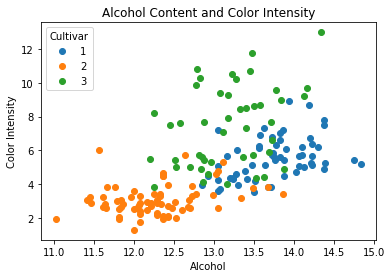

In [24]:
groups = src.groupby('cultivar')

fig, ax = plt.subplots()
ax.set_title('Alcohol Content and Color Intensity')
ax.set_xlabel('Alcohol')
ax.set_ylabel('Color Intensity')
ax.margins(0.05) 

for name, group in groups:
    ax.plot(group.alco, group.color_int, marker='o', linestyle='', ms=6, label=name)
ax.legend(title='Cultivar', loc = "upper left")

plt.show()

#### 1B)

In [25]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
C = np.zeros(200)
MSE_C = np.zeros(200)

for c in range(200):
    k_ind = int(0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='newton-cg', C = (c/100 + 0.01))
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    C[c] = c/100 + 0.01
    MSE_C[c] =  MSE.mean()
MSE_logit = pd.DataFrame({'C':C, 'MSE':MSE_C})

In [26]:
MSE_logit.sort_values(['MSE']).head(10)


,C,MSE
43,0.44,0.068182
44,0.45,0.068182
42,0.43,0.068182
41,0.42,0.068182
40,0.41,0.068182
39,0.40,0.068182
27,0.28,0.068182
28,0.29,0.068182
29,0.30,0.068182
30,0.31,0.068182


##### For the logistiv method when C = 0.44, the penalty is 'l2', the lowest MSE is 0.068182. As we will see in the following methodologies, this is less than ideal.

#### 1C)

In [27]:
MSE_loop = pd.DataFrame({"n_estimator" : np.zeros(5),
                         "min_sample_leaf" : np.zeros(5),
                         "max_depth" : np.zeros(5),
                         "MSE" : np.zeros(5)})
MSE_RF = MSE_loop[:0]

for ml in range(15):
    for md in range(15):
        for tree in range(5):
            RF = RandomForestClassifier(n_estimators = (tree * 50 + 50),
                                        min_samples_leaf = (ml * 5 + 5),
                                        max_depth = (md + 1), bootstrap=True, 
                                        oob_score=True, random_state=22)
            RF.fit(X, y)
            MSE_loop["n_estimator"][tree] = tree * 50 + 50
            MSE_loop["max_depth"][tree] = md + 1
            MSE_loop["min_sample_leaf"][tree] = ml * 5 + 5
            MSE_loop["MSE"][tree] = 1 - RF.oob_score_
        MSE_RF = pd.concat([MSE_RF, MSE_loop])

In [28]:
MSE_RF.index = range(len(MSE_RF))
MSE_RF.sort_values(['MSE']).head(10)

,MSE,max_depth,min_sample_leaf,n_estimator
96,0.068182,5.0,10.0,100.0
126,0.068182,11.0,10.0,100.0
116,0.068182,9.0,10.0,100.0
131,0.068182,12.0,10.0,100.0
111,0.068182,8.0,10.0,100.0
106,0.068182,7.0,10.0,100.0
121,0.068182,10.0,10.0,100.0
101,0.068182,6.0,10.0,100.0
136,0.068182,13.0,10.0,100.0
86,0.068182,3.0,10.0,100.0


##### For the random forrest method, when max_depth  is 7, and min_samples_leaft is 10, n_estimator is 100, we achieve the lowest MSE of 0.068182. This is is similar to the MSE from the logistic method.

#### 1D)

In [29]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
MSE_C = pd.DataFrame({"Cost" : np.zeros(80),
                      "Gamma" : np.zeros(80),
                      "MSE" : np.zeros(80)})
MSE_SVM = MSE_C[:0]

for g in range(80):
    for c in range(80):
        k_ind = int(0)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            svc = svm.SVC(kernel='rbf', gamma = (g/20 + 0.05),
                          C=c/20 + 0.05)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
        MSE_C['Cost'][c] = c/20 + 0.05
        MSE_C['Gamma'][c] = g/20 + 0.05
        MSE_C['MSE'][c] =  MSE.mean()
    MSE_SVM = pd.concat([MSE_SVM, MSE_C])

In [30]:
MSE_SVM.index = range(len(MSE_SVM))
MSE_SVM.sort_values(['MSE']).head(10)

,Cost,Gamma,MSE
2659,1.00,1.70,0.045455
2578,0.95,1.65,0.045455
2658,0.95,1.70,0.045455
224,3.25,0.15,0.051136
225,3.30,0.15,0.051136
226,3.35,0.15,0.051136
227,3.40,0.15,0.051136
228,3.45,0.15,0.051136
229,3.50,0.15,0.051136
218,2.95,0.15,0.051136


#### When cost is 1, gamma is 1.7, the SVM model reaches its lowest MSE of 0.045455. This is an improvement over the previous models. 

#### 1E) 

In [31]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
activ = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_al = pd.DataFrame({"activation" : np.zeros(20),
                       "hidden layer" : np.zeros(20),
                       "alpha" : np.zeros(20),
                       "MSE":np.zeros(20)})
MSE_mlp = MSE_al[:0]

for ac in range(4):
    for h in range(8):
        for al in range(20):
            k_ind = int(0)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                mlp = MLPClassifier(activation=activ[ac], solver='lbfgs',
                                    alpha=(al/20 + 0.05), random_state=25,
                                    hidden_layer_sizes = ((50 * (h + 1)),))
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind += 1
            MSE_al['activation'][al] = activ[ac]
            MSE_al['hidden layer'][al] = 50 * (h + 1)
            MSE_al['alpha'][al] = al/20 + 0.05
            MSE_al['MSE'][al] =  MSE.mean()
        MSE_mlp = pd.concat([MSE_mlp, MSE_al])

In [32]:
MSE_mlp.index = range(len(MSE_mlp))
MSE_mlp.sort_values(['MSE']).head(10)

,MSE,activation,alpha,hidden layer
585,0.034091,relu,0.30,300.0
551,0.039773,relu,0.60,200.0
549,0.039773,relu,0.50,200.0
561,0.039773,relu,0.10,250.0
584,0.039773,relu,0.25,300.0
527,0.039773,relu,0.40,150.0
568,0.039773,relu,0.45,250.0
605,0.045455,relu,0.30,350.0
531,0.045455,relu,0.60,150.0
533,0.045455,relu,0.70,150.0


##### For the neural net method, when activation = 'relu', alpha is 0.30 and hidden_layer_sizes is 300, the MLP model has the lowest MSE of 0.034091. This is a significant improvement over the other methods.

#### 1F)

Text(0,0.5,'Error Rate/MSE')

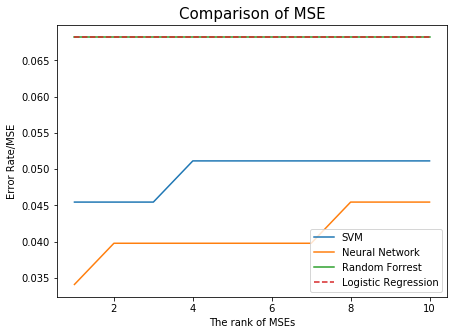

In [33]:
n = 10
best_logit = np.array(MSE_logit.sort_values(['MSE']).head(n)['MSE'])
best_RF = np.array(MSE_RF.sort_values(['MSE']).head(n)['MSE'])
best_SVM = np.array(MSE_SVM.sort_values(['MSE']).head(n)['MSE'])
best_mlp = np.array(MSE_mlp.sort_values(['MSE']).head(n)['MSE'])
rank = np.array(range(n)) + 1

Com = pd.DataFrame({'Logit':best_logit, 
                    'RF':best_RF,
                    'SVM':best_SVM,
                    'MLP':best_mlp,
                    'rank':rank})


plt.figure(figsize=(7,5))
plt.plot(Com['rank'], Com['SVM'], label='SVM')
plt.plot(Com['rank'], Com['MLP'], label='Neural Network')
plt.plot(Com['rank'], Com['RF'], label='Random Forrest')
plt.plot(Com['rank'], Com['Logit'], label='Logistic Regression', ls =  'dashed')
plt.legend(loc='best')
plt.title('Comparison of MSE', fontsize = 15)
plt.xlabel('The rank of MSEs')
plt.ylabel("Error Rate/MSE")

##### As shown in the above graph and by comparing the MSEs, the neural net method yielded the lowest MSE by far. The SVM yielded the second lowest and the Logit and RF Methods were essentially identical.